<h1>Imports<h1>

In [1]:
config = {
    'gdt': {
        'depth': 5,
                
        'learning_rate_index': 0.05,
        'learning_rate_values': 0.01,
        'learning_rate_leaf': 0.005,
        
        'dropout': 0,
        
        
        'initializer_values': 'GlorotUniform', 
        'initializer_index': 'GlorotUniform', 
        'initializer_leaf': 'GlorotUniform', 
        
        'optimizer': 'adam', 
        
        'batch_size': 512,
        'epochs': 10_000,
        
        'restarts': 10,
        'restart_type': 'loss', #'loss', 'metric'
        
        'early_stopping_epochs': 200,
        'early_stopping_type': 'loss', #'loss', 'metric'
        'early_stopping_epsilon': 0.0,
    },
    
    'preprocessing': {
        'balance_threshold': 0,#.25, #if minclass fraction less than threshold/num_classes | #0=no rebalance, 1=rebalance all
        'normalization_technique': 'mean', #'min-max'
    },

    'computation': {
        'random_seed': 42,
        'trials': 10, # fixed to 1 for HPO
        
        'use_best_hpo_result': True,
        'force_depth': False,
        
        'use_gpu': True,
        'gpu_numbers': '5',#'1',
        'n_jobs': 10, #vorher 20
        'verbosity': 0,
        
        
        'hpo': None,#'binary', #'binary', 'multi', 'regression'
        'search_iterations': 300,
        'cv_num': 3,     
        
        'metrics_class': ['f1', 'roc_auc', 'accuracy'],
        
        'metrics_reg': ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_absolute_error', 'neg_mean_squared_error'],
        
        'eval_metric_class': ['f1', 'roc_auc'], #f1 accuracy
        'eval_metric_reg': 'r2', #r2 mae        
        
        
    },
    
    'benchmarks': {
        'sklearn': True,
        #'GeneticTree': True,        
    }
}

In [2]:
import numpy as np
np.set_printoptions(suppress=True)

import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, ParameterGrid, ParameterSampler, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
#from pydl85 import DL85Classifier

from livelossplot import PlotLosses

import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from IPython.display import Image
from IPython.display import display, clear_output

import pandas as pd

if config['computation']['use_gpu']:
    os.environ['CUDA_VISIBLE_DEVICES'] = str(config['computation']['gpu_numbers'])
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
    os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/local/cuda-11.6"
    os.environ['TF_XLA_FLAGS'] = "--tf_xla_enable_xla_devices --tf_xla_auto_jit=2"    
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false' 
#os.environ['TF_XLA_FLAGS'] = "--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit" 


import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["PYTHONWARNINGS"] = "ignore"
import logging

import tensorflow as tf
import tensorflow_addons as tfa

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

np.seterr(all="ignore")

from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


import seaborn as sns
sns.set_style("darkgrid")

import time
import random

from utilities.utilities_GDT import *
from utilities.GDT import *

from joblib import Parallel, delayed

from itertools import product
from collections.abc import Iterable

from copy import deepcopy
from pathlib import Path
import pickle
import dill

tf.random.set_seed(config['computation']['random_seed'])
np.random.seed(config['computation']['random_seed'])
random.seed(config['computation']['random_seed'])

from datetime import datetime
timestr = datetime.utcnow().strftime('%Y-%m-%d--%H-%M-%S%f')
print(timestr)
os.makedirs(os.path.dirname("./evaluation_results/latex_tables/" + timestr +"/"), exist_ok=True)

filepath = './evaluation_results/depth' + str(config['gdt']['depth']) + '/' + timestr + '/'
Path(filepath).mkdir(parents=True, exist_ok=True)    


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

2022-10-31--13-11-35588608


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  1
Num XLA-GPUs Available:  1


<h1>Evaluation<h1>

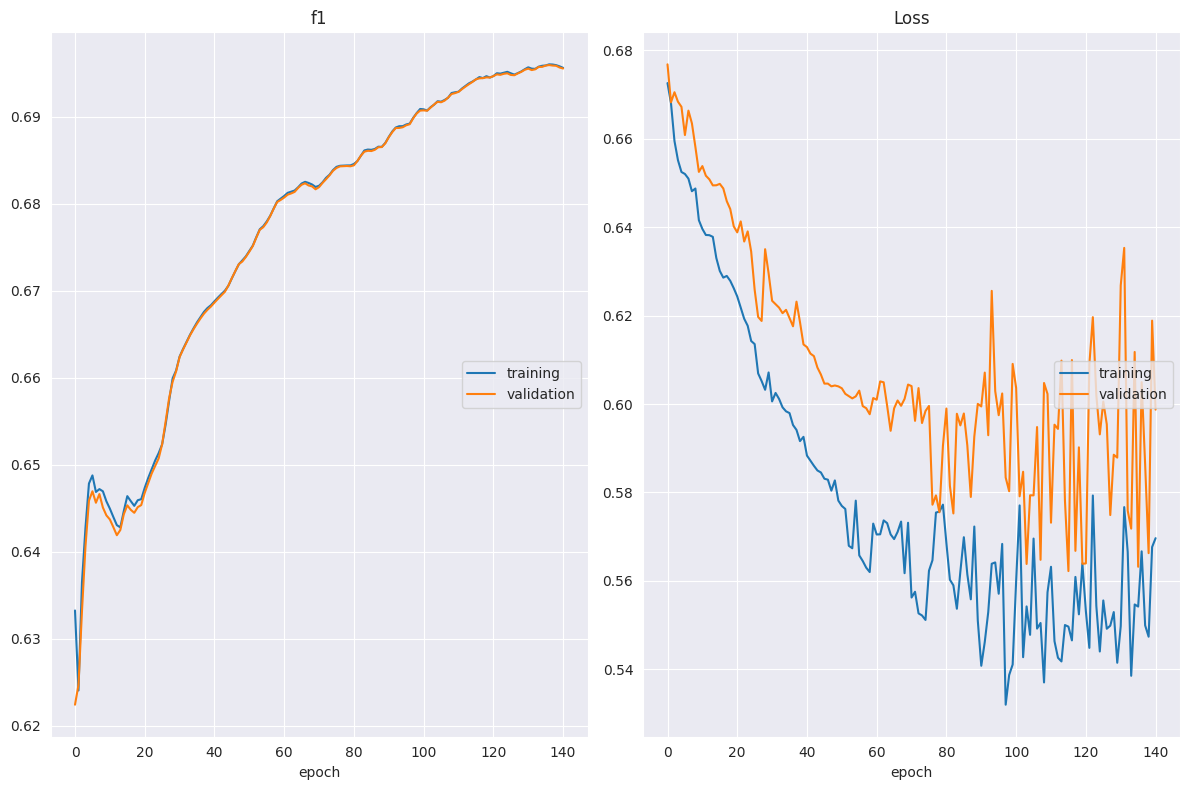

f1
	training         	 (min:    0.624, max:    0.696, cur:    0.696)
	validation       	 (min:    0.622, max:    0.696, cur:    0.696)
Loss
	training         	 (min:    0.532, max:    0.673, cur:    0.570)
	validation       	 (min:    0.562, max:    0.677, cur:    0.599)
Test f1 GDT (0) 0.7539193023011452
Test roc_auc GDT (0) 0.7175141242937852
Test accuracy GDT (0) 0.775
________________________________________________________________________________________________________
Test f1 sklearn (0) 0.7631977559607293
Test roc_auc sklearn (0) 0.726289217454021
Test accuracy sklearn (0) 0.76
________________________________________________________________________________________________________


In [4]:


dataset_dict, config_training, metrics = prepare_training(identifier = 'BIN:German', config = config)

model_dict = {}

verbosity = 1

model_dict['GDT'] = GDT(number_of_variables = dataset_dict['number_of_variables'],
            number_of_classes = dataset_dict['number_of_classes'],

            objective = config_training['gdt']['objective'],

            depth = config_training['gdt']['depth'],

            learning_rate_index = config_training['gdt']['learning_rate_index'],
            learning_rate_values = config_training['gdt']['learning_rate_values'],
            learning_rate_leaf = config_training['gdt']['learning_rate_leaf'],

            optimizer = config_training['gdt']['optimizer'],

            loss = 'crossentropy',

            initializer_values = config_training['gdt']['initializer_values'],
            initializer_index = config_training['gdt']['initializer_index'],
            initializer_leaf = config_training['gdt']['initializer_leaf'],        

            random_seed = config_training['computation']['random_seed'],
            verbosity = verbosity)#5      


history = model_dict['GDT'].fit(dataset_dict['X_train'],
          dataset_dict['y_train'],

          batch_size=config_training['gdt']['batch_size'], 
          epochs=config_training['gdt']['epochs'], 

          restarts = 0,#config_test['gdt']['restarts'], 
          #restart_type=config_test['gdt']['restart_type'], 

          #early_stopping_epochs=config_training['gdt']['early_stopping_epochs'], 
          #early_stopping_type=config_test['gdt']['early_stopping_type'],

          valid_data=(dataset_dict['X_valid'], dataset_dict['y_valid']))


model_dict['sklearn'] = DecisionTreeClassifier(max_depth=config_training['gdt']['depth'], 
                                      random_state=config_training['computation']['random_seed'])

model_dict['sklearn'].fit(dataset_dict['X_train'], 
                          dataset_dict['y_train'])


# model_dict['GeneticTree'] = GeneticTree()
# model_dict['GeneticTree'] = model_dict['GeneticTree'].fit(dataset_dict['X_train'].values, 
#                                                           dataset_dict['y_train'].values)        


scores_dict = calculate_scores(model_dict = model_dict, 
                               dataset_dict = dataset_dict, 
                               scores_dict = prepare_score_dict(config=config_training), 
                               metrics = metrics)           

#model.set_params(**config_training['gdt'])   

<IPython.core.display.Javascript object>


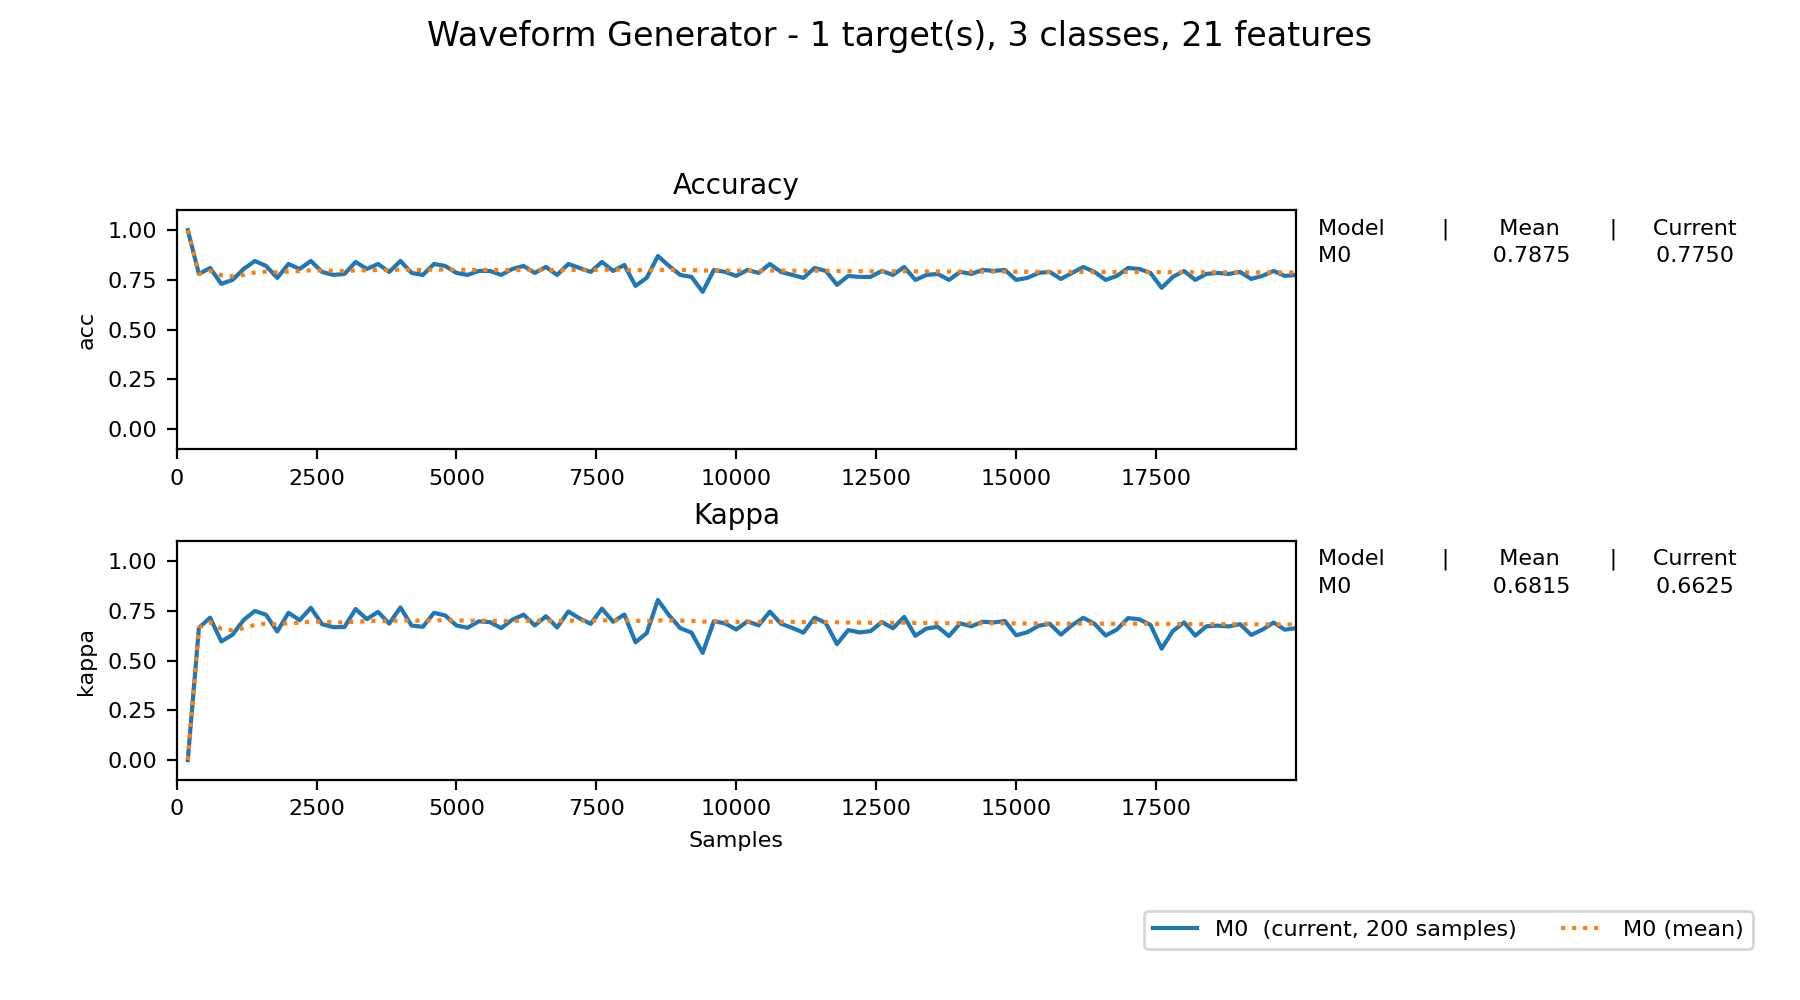

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [38.66s]
Processed samples: 20000
Mean performance:
M0 - Accuracy     : 0.7875
M0 - Kappa        : 0.6815


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05)]

In [1]:
%matplotlib notebook
%matplotlib ipympl
from skmultiflow.data import WaveformGenerator
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.evaluation import EvaluatePrequential
# 1. Create a stream
stream = WaveformGenerator()
# 2. Instantiate the HoeffdingTreeClassifier
ht = HoeffdingTreeClassifier()
# 3. Setup the evaluator
evaluator = EvaluatePrequential(show_plot=True,
                                pretrain_size=200,
                                max_samples=20000)
# 4. Run evaluation
evaluator.evaluate(stream=stream, model=ht, model_names=None)

In [20]:
%matplotlib notebook
%matplotlib ipympl
from skmultiflow.data import SEAGenerator
from skmultiflow.bayes import NaiveBayes
import pandas as pd
stream = SEAGenerator(random_state=1)
classifier = NaiveBayes()
n_samples = 0
correct_cnt = 0
max_samples = 2000
X_Train = pd.DataFrame()
y_train = pd.DataFrame()
# Prequential evaluation loop
while n_samples < max_samples and stream.has_more_samples():
    X, y = stream.next_sample()
    print(str(X) + "  " + str(y))
    X_Train = pd.concat([X_Train, pd.DataFrame(X)])
    y_train = pd.concat([y_train, pd.DataFrame(y)])
    # Predict class for new data y_pred = classifier.predict(X) if y[0] == y_pred[0]:
    correct_cnt += 1
    # Partially fit (train) model with new data classifier.partial_fit(X, y)
    n_samples += 1
print(str(n_samples) + ' samples analyzed.')
print('Accuracy: ' + str((correct_cnt / n_samples)))


[[4.17022005e+00 7.20324493e+00 1.14374817e-03]]  [1]
[[1.46755891 0.92338595 1.86260211]]  [0]
[[3.96767474 5.38816734 4.19194514]]  [1]
[[2.0445225  8.78117436 0.27387593]]  [1]
[[4.17304802 5.58689828 1.40386939]]  [1]
[[8.00744569 9.68261576 3.13424178]]  [1]
[[8.76389152 8.94606664 0.85044211]]  [1]
[[1.6983042  8.78142503 0.98346834]]  [1]
[[9.5788953  5.33165285 6.91877114]]  [1]
[[6.86500928 8.34625672 0.18288277]]  [1]
[[9.88861089 7.48165654 2.80443992]]  [1]
[[1.03226007 4.47893526 9.08595503]]  [0]
[[2.87775339 1.30028572 0.19366958]]  [0]
[[2.11628116 2.65546659 4.91573159]]  [0]
[[5.74117605 1.46728575 5.89305537]]  [0]
[[1.02334429 4.14055988 6.94400158]]  [0]
[[0.49953459 5.35896406 6.63794645]]  [0]
[[9.44594756 5.86555041 9.03401915]]  [1]
[[1.39276347 8.07391289 3.97676837]]  [1]
[[9.2750858  3.4776586  7.50812103]]  [1]
[[8.83306091 6.23672207 7.50942434]]  [1]
[[2.69927892 8.95886218 4.2809119 ]]  [1]
[[6.63441498 6.2169572  1.14745973]]  [1]
[[4.49912133 5.7838961

[[1.83953442 4.62839119 4.28932334]]  [0]
[[1.6151077  3.42440641 2.61880404]]  [0]
[[8.00332246 4.26639158 6.07015461]]  [1]
[[5.09613294 2.96947086 8.59650954]]  [1]
[[6.33474013 1.247513   4.70587879]]  [0]
[[9.48299174 6.4508564  1.51724871]]  [1]
[[5.65662113 4.68665838 4.28037469]]  [1]
[[8.49969889 7.5112104  5.7936054 ]]  [1]
[[0.64739983 9.91346509 0.52994543]]  [1]
[[4.22752662 1.07508876 6.23670411]]  [0]
[[2.84623881 0.61036681 7.03519331]]  [0]
[[3.78580593 1.8819426  7.47004829]]  [0]
[[7.95301167 4.87900939 5.25669444]]  [1]
[[6.4423202  3.50656502 2.29205027]]  [1]
[[3.82467457 4.6978904  9.79483354]]  [1]
[[7.74410133 5.52767597 8.89131089]]  [1]
[[2.4551868  9.1101924  0.43534264]]  [1]
[[5.56406916 3.76363217 9.95052322]]  [1]
[[5.1670636  0.31097075 5.71175739]]  [0]
[[6.309592   9.80923676 8.74902551]]  [1]
[[7.0846087  7.7746875  4.94843084]]  [1]
[[1.50784398 3.69399926 1.42221253]]  [0]
[[4.77012994 4.48878837 8.85997971]]  [1]
[[4.09090832 2.68892022 0.72012035

[[5.51995027 9.63915889 2.80955537]]  [1]
[[3.9646269  6.28023232 3.00632289]]  [1]
[[0.69785979 0.4187757  0.49396385]]  [0]
[[3.95350474 9.55389989 1.1079544 ]]  [1]
[[5.27621508 3.53242406 1.98199229]]  [1]
[[0.4382151  7.13163973 6.53840199]]  [0]
[[7.18939488 1.09975972 9.38719173]]  [1]
[[6.5903566  3.78831169 4.16566729]]  [1]
[[9.3528377  8.63592955 4.77923849]]  [1]
[[8.75403862 9.49264434 6.39184756]]  [1]
[[3.51624906 9.18028319 8.3675205 ]]  [1]
[[8.6762721  8.49871881 8.08411357]]  [1]
[[5.36002575 9.00783115 7.70831831]]  [1]
[[9.77880393 2.50773157 3.33610229]]  [1]
[[8.08715348 9.00340005 0.11589589]]  [1]
[[2.35521957 2.95935052 7.37995496]]  [0]
[[4.6179941  3.65274461 5.84691613]]  [1]
[[5.50579559 6.15477071 3.95648272]]  [1]
[[2.51203183 6.55760768 9.60397148]]  [1]
[[7.23361044 1.08995034 5.43787492]]  [1]
[[2.42947126 9.13843875 6.22312529]]  [1]
[[7.70132188 1.0550708  5.55225319]]  [1]
[[5.80984073 2.52980113 6.49466808]]  [1]
[[5.24185615 6.57521408 8.13293845

[[8.64416262 4.18708675 6.54469351]]  [1]
[[6.64150816 3.03080676 6.19945694]]  [1]
[[3.22366675 6.10205059 1.60323232]]  [1]
[[9.45634285 3.83914242 1.88962593]]  [1]
[[8.40907831 8.42667723 8.27803239]]  [1]
[[2.6704031  9.99875788 1.19683277]]  [1]
[[7.90026151 1.2221391  6.62409181]]  [1]
[[1.94289982 8.78630027 1.81487398]]  [1]
[[7.40826878 5.62672887 6.28841569]]  [1]
[[3.08036987 5.86962207 3.95463716]]  [1]
[[8.51954645 1.90222089 9.03272701]]  [1]
[[9.43124331 6.17382313 7.90095521]]  [1]
[[5.31144694 3.27593899 1.29364707]]  [1]
[[2.14976481 0.32865256 2.7488683 ]]  [0]
[[8.75530315 0.81236562 1.83895599]]  [1]
[[9.19225891 2.51458452 0.21301131]]  [1]
[[6.8222064  3.10662696 4.72373442]]  [1]
[[3.73868572 8.74487797 7.26172588]]  [1]
[[3.51065523 9.37174089 4.79100574]]  [1]
[[7.36647205 8.09337969 3.96259367]]  [1]
[[8.17277026 7.17557203 9.40849209]]  [1]
[[1.78913336 2.27919412 7.15986447]]  [0]
[[6.03179554 8.77299764 2.51990462]]  [1]
[[4.94646848 3.15027089 5.45439089

[[0.38387432 8.79300844 5.87939745]]  [1]
[[6.73851877 0.39442799 3.30321203]]  [0]
[[6.83637465 3.98011715 4.78954092]]  [1]
[[7.8829452  0.46512682 2.81125646]]  [1]
[[7.90133502 6.01599336 7.30488669]]  [1]
[[2.54923589 0.4209176  5.00012398]]  [0]
[[0.13530508 4.40879038 0.04786418]]  [0]
[[1.83358726 7.12741784 1.59648512]]  [1]
[[2.06178164 3.52216274 2.30578472]]  [0]
[[4.90269956 8.73833506 1.30085973]]  [1]
[[7.76613634 9.81210169 6.7337773 ]]  [1]
[[7.59772956 0.74635215 7.62772464]]  [1]
[[5.59209716 4.9272083  9.36527423]]  [1]
[[0.09566894 2.51951423 5.05676463]]  [0]
[[3.71292424 2.92711375 2.02367346]]  [0]
[[3.15922905 4.92467986 8.11290892]]  [1]
[[4.08608496 1.76904222 3.9765209 ]]  [0]
[[9.90584593 2.84195076 1.65639676]]  [1]
[[2.11467344 0.76047691 3.64907698]]  [0]
[[8.87588792 7.8025961  1.09064957]]  [1]
[[1.09598607 7.20207747 5.72824298]]  [1]
[[9.05328036 8.74566515 8.43851731]]  [1]
[[2.22951412 9.97111655 8.17338365]]  [1]
[[3.73277878 8.12186976 5.28384697

[[3.35997001 3.24454327 2.29853189]]  [0]
[[6.87073346 7.52781192 3.38283416]]  [1]
[[7.97382274 6.47467739 0.22978172]]  [1]
[[9.54394832 8.83154655 3.25217951]]  [1]
[[4.79175082 2.02068721 2.71449408]]  [0]
[[0.55575456 4.37136111 9.04582888]]  [0]
[[5.45456473 2.2699961  0.4640083 ]]  [0]
[[2.15125693 8.73393415 9.8832861 ]]  [1]
[[4.43309955 3.69197291 5.36463564]]  [1]
[[3.95999761 1.83864064 5.85274246]]  [0]
[[8.93977665 6.44410797 0.94544264]]  [1]
[[1.28974321 1.1882084  2.65548902]]  [0]
[[6.98220946 5.58852134 2.55226619]]  [1]
[[9.29750994 1.85319203 7.34207407]]  [1]
[[6.69456208 2.03695669 1.29165996]]  [1]
[[1.30308181 8.25700001 5.23644529]]  [1]
[[5.68126733 2.6063738  5.84470205]]  [1]
[[2.19052052 5.18506082 8.35415783]]  [0]
[[0.94190741 1.34068325 3.90300596]]  [0]
[[8.91220602 8.91291488 0.29824101]]  [1]
[[3.88352713 1.76374745 9.1868634 ]]  [0]
[[7.33985962 9.56915634 4.77718045]]  [1]
[[4.28219382 8.13449255 7.61698496]]  [1]
[[3.36600007 7.66594404 9.21617804

[[7.50590411 3.12020272 5.708646  ]]  [1]
[[8.11464609 2.0146632  6.76242716]]  [1]
[[4.14385679 4.93696805 5.14249396]]  [1]
[[0.51650761 5.71552824 4.89760092]]  [0]
[[6.6991672  7.69440011 5.40059577]]  [1]
[[2.35080865 0.20439751 3.27778292]]  [0]
[[7.84569113 5.32272956 4.77426501]]  [1]
[[0.17417185 6.94990765 3.11959587]]  [0]
[[6.06806645 1.82142657 2.5027259 ]]  [0]
[[2.62622672 2.39417049 3.5903135 ]]  [0]
[[8.69210306 5.14035779 0.51747681]]  [1]
[[1.81189188 6.68741254 8.35371715]]  [1]
[[1.26845909 5.23311322 8.50611045]]  [0]
[[7.30046476 7.85459646 8.36595545]]  [1]
[[8.9773919  6.47791234 9.4463739 ]]  [1]
[[8.72428624 5.9565536  3.44348984]]  [1]
[[4.32381028 1.2654566  9.68568733]]  [0]
[[5.61259424 6.70612298 9.97724222]]  [1]
[[5.3453996  3.90978708 5.4114757 ]]  [1]
[[4.40742258 4.61464137 5.95891644]]  [1]
[[5.90149374 7.2938276  5.80902624]]  [1]
[[4.96788445 4.30088817 2.10073853]]  [1]
[[4.57388676 4.33552713 7.79283759]]  [1]
[[6.73368333 1.66038684 8.24058984

[[4.60679902 0.24607321 0.97131286]]  [0]
[[3.89221229 7.15965874 0.52882073]]  [1]
[[1.47469963 9.36675284 8.65735047]]  [1]
[[1.6129403  3.54824295 9.34832593]]  [0]
[[4.71068414 4.02367765 8.96553937]]  [1]
[[7.78675403 8.33343319 3.07089341]]  [1]
[[4.52698697 1.79305693 5.9630226 ]]  [0]
[[4.37343575 3.73344761 7.04314823]]  [1]
[[6.86347433 5.74920667 3.35007102]]  [1]
[[0.4289581  5.4882531  5.95599425]]  [0]
[[3.56281697 8.63018499 6.1937091 ]]  [1]
[[1.04610996 2.3791776  7.19280612]]  [0]
[[4.46621874 0.39252277 0.5039634 ]]  [0]
[[8.64326467 1.36094967 6.58261735]]  [1]
[[7.26595545 5.82568857 1.79417896]]  [1]
[[5.95444013 5.46184932 7.27123261]]  [1]
[[0.70607501 0.88213984 3.27727367]]  [0]
[[7.48217174 6.07638869 0.95431337]]  [1]
[[9.16097815 8.24380196 6.73309054]]  [1]
[[1.5012412  0.65512577 7.4797998 ]]  [0]
[[2.402431   5.61935955 0.80825776]]  [1]
[[4.50436385 2.40552261 5.65379051]]  [0]
[[9.11671189 7.82643868 9.76828331]]  [1]
[[1.41021438 4.09968224 7.92297256

[[2.15386328 3.83859721 2.69416757]]  [0]
[[2.14974857 4.30715404 2.37348928]]  [0]
[[7.38228583 1.90312305 9.80479283]]  [1]
[[0.91927697 6.62203942 1.24135677]]  [0]
[[5.54910703 9.12217951 8.40780911]]  [1]
[[8.80599827 8.13531095 1.94638634]]  [1]
[[7.19227265 6.52572655 4.05657296]]  [1]
[[3.78993186 0.33161211 2.44203547]]  [0]
[[4.747147   1.95541065 9.33438819]]  [0]
[[7.10189597 2.52158149 1.25755014]]  [1]
[[3.06874615 5.56235015 0.05695578]]  [1]
[[3.24373924 2.08877817 7.64696794]]  [0]
[[3.67228639 0.61461814 7.99073715]]  [0]
[[9.79003122 9.50643274 4.87089595]]  [1]
[[6.94165376 7.24605949 8.6835509 ]]  [1]
[[3.98953671 7.88843309 2.22687134]]  [1]
[[7.80965493 6.04659764 1.99041178]]  [1]
[[9.80274528 1.91916362 2.42707547]]  [1]
[[7.95043142 8.59923091 7.68784925]]  [1]
[[2.62593209 5.91108933 5.56326656]]  [1]
[[2.44804033 6.29170525 3.61440067]]  [1]
[[4.23689223 6.04982172 0.67116673]]  [1]
[[9.36317746 1.48083988 8.81589345]]  [1]
[[4.82828376 4.90967342 2.34800188

,0
0,1
0,0
0,1
0,1
0,1
...,...
0,1
0,1
0,1
0,1


In [15]:
pd.DataFrame??